<a href="https://colab.research.google.com/github/indahnr/Deep_Learning/blob/main/week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#WGAN

In [ ]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
layers = keras.layers

print("tensorflow version", tf.__version__)
print("keras version", keras.__version__)
print("numpy version", np.__version__)

tensorflow version 2.8.2
keras version 2.8.0
numpy version 1.21.6


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found. If you use google colab, request a GPU via "Edit" --> "Notebook Settings"')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import gdown

url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz"
output = 'airshowers.npz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz
To: /content/airshowers.npz
100%|██████████| 65.6M/65.6M [00:00<00:00, 163MB/s]


'airshowers.npz'

In [ ]:
file = np.load(output)
shower_maps = file['shower_maps']
nsamples = len(shower_maps)

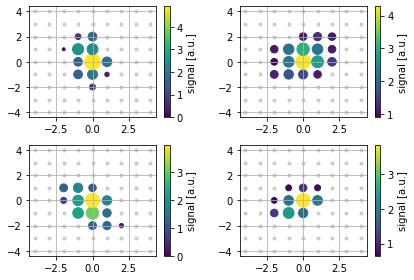

In [ ]:
def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(np.random.choice(nsamples, 4)):
    plt.subplot(2,2,i+1)
    footprint=shower_maps[j,...,0]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                           s=marker_size, alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('signal [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(9 * 9 * latent_size)(latent)
    z = layers.Reshape((9, 9, latent_size))(z)
    z = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(z)
    return keras.models.Model(latent, z, name="generator")

In [ ]:
latent_size = 128
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 10368)             1337472   
                                                                 
 reshape (Reshape)           (None, 9, 9, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 1)           1153      
                                                                 
Total params: 1,338,625
Trainable params: 1,338,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def critic_model():
    image = layers.Input(shape=(9,9,1), name="images")
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(9, 9, 1))(image)
    x = layers.LeakyReLU()(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(100)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)
    return keras.models.Model(image, x, name="critic")

In [ ]:
critic = critic_model()
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 9, 9, 1)]         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 9, 9, 64)          0         
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                            

In [ ]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

In [ ]:
make_trainable(critic, False) 
make_trainable(g, True) # This is in principal not needed here

In [ ]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 9, 9, 1)           1338625   
                                                                 
 critic (Functional)         (None, 1)                 7241      
                                                                 
Total params: 1,345,866
Trainable params: 1,338,625
Non-trainable params: 7,241
_________________________________________________________________


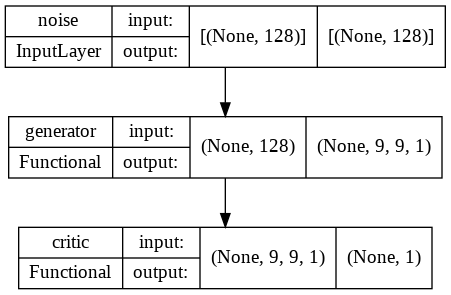

In [ ]:
keras.utils.plot_model(generator_training, show_shapes=True)

In [ ]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss - critic maximises the distance between its output for real and generated samples.
    To achieve this generated samples have the label -1 and real samples the label 1. Multiplying the outputs by the labels results to the wasserstein loss via the Kantorovich-Rubinstein duality"""
    return K.mean(y_true * y_pred)

generator_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])

In [ ]:
BATCH_SIZE = 64

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [ ]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)

critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

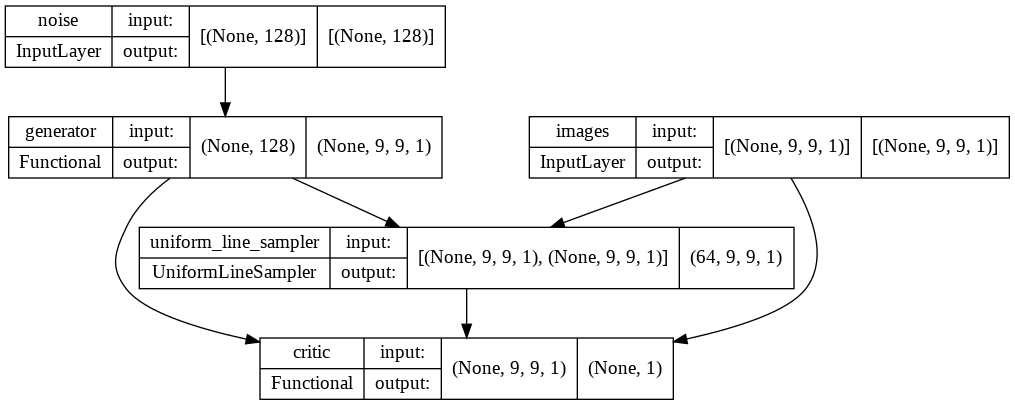

In [ ]:
keras.utils.plot_model(critic_training, show_shapes=True)

In [ ]:
critic_training.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 generator (Functional)         (None, 9, 9, 1)      1338625     ['noise[0][0]']                  
                                                                                                  
 images (InputLayer)            [(None, 9, 9, 1)]    0           []                               
                                                                                                  
 uniform_line_sampler (UniformL  (64, 9, 9, 1)       0           ['generator[1][0]',              
 ineSampler)                                                      'images[0][0]']           

In [ ]:
from functools import partial

def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    gradients = K.gradients(y_pred, averaged_batch)
    gradients_sqr_sum = K.sum(K.square(gradients)[0], axis=(1, 2, 3))
    gradient_penalty = penalty_weight * K.square(1 - K.sqrt(gradients_sqr_sum))
    return K.mean(gradient_penalty)


gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=10)  # construct the gradient penalty
gradient_penalty.__name__ = 'gradient_penalty'

In [ ]:
critic_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

In [ ]:
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE)  # keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss

In [ ]:
EPOCHS = 1
critic_iterations = 1

generator_loss = []
critic_loss = []

iterations_per_epoch = nsamples // (critic_iterations * BATCH_SIZE)
iters = 0

for epoch in range(EPOCHS):
    print("epoch: ", epoch)  
    
    for iteration in range(iterations_per_epoch):

        for j in range(critic_iterations):

            noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
            shower_batch = shower_maps[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]  # take batch of shower maps
            critic_loss.append(critic_training.train_on_batch([noise_batch, shower_batch], [negative_y, positive_y, dummy]))  # train the critic

        noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  # train the generator
        iters+=1
        
        generated_maps = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
        
        if iters % 100 == 1:
            print("iteration", iters)
            print("critic loss:", critic_loss[-1])
            print("generator loss:", generator_loss[-1])

            for i in range(4):
                plt.subplot(2,2,i+1)
                footprint=generated_maps[i,...,0]
                xd, yd = rectangular_array()
                mask = footprint != 0
                mask[5, 5] = True
                marker_size = 50 * footprint[mask]
                plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
                circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                                       s=marker_size, alpha=1, label="loud")
                cbar = plt.colorbar(circles)
                cbar.set_label('signal [a.u.]')
                plt.grid(True)

            plt.suptitle("iteration %i" % iters)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig("./fake_showers_iteration_%.6i.png" % iters)
            plt.close("all")

epoch:  0


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


iteration 1
critic loss: [-0.17362368, 0.2713012, -0.69978887, 0.25486398]
generator loss: -0.31143817
iteration 101
critic loss: [-3.628911, 0.83242035, -5.0324545, 0.5711232]
generator loss: -0.8087987
iteration 201
critic loss: [-2.7842598, 1.6598004, -4.7914076, 0.34734738]
generator loss: -1.2633984
iteration 301
critic loss: [-1.3723149, 2.1290262, -3.736395, 0.23505378]
generator loss: -2.1202283
iteration 401
critic loss: [-0.1098215, 0.94727004, -1.4026251, 0.34553355]
generator loss: -0.8387108
iteration 501
critic loss: [0.6793639, 1.4817299, -1.0780249, 0.2756589]
generator loss: -1.1845435
iteration 601
critic loss: [0.5014148, 2.9719307, -2.625228, 0.15471193]
generator loss: -3.0934947
iteration 701
critic loss: [0.85766387, -0.3400339, 0.8657303, 0.33196744]
generator loss: 0.23212641
iteration 801
critic loss: [0.23354554, -3.2193804, 3.2435708, 0.20935512]
generator loss: 3.2058287
iteration 901
critic loss: [0.95407283, 3.1745045, -2.4043045, 0.18387283]
generator lo

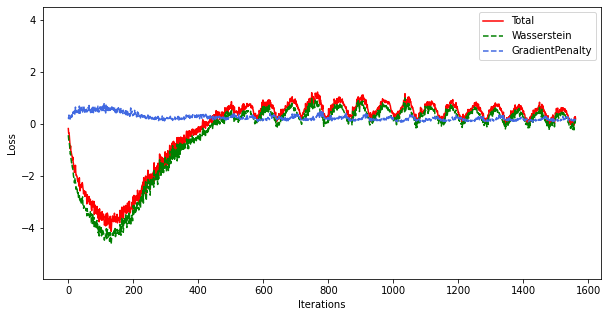

In [ ]:
critic_loss = np.array(critic_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'GradientPenalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.ylim(np.min(critic_loss)-0.5, 4.5)
plt.show()

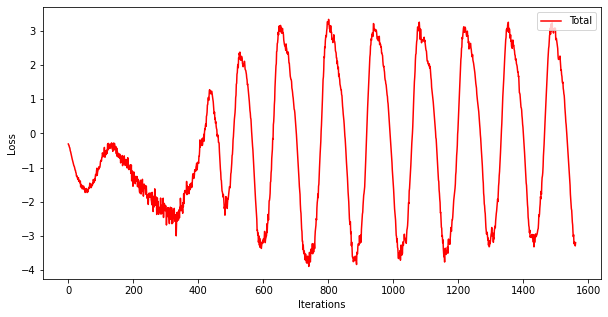

In [ ]:
generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.show()

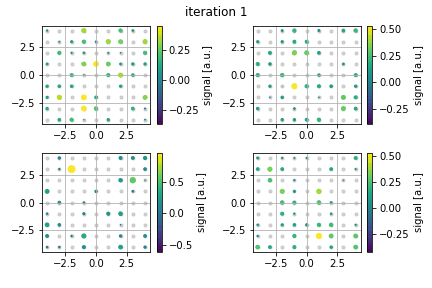

In [ ]:
import imageio
import glob

out_file = 'generated_shower_samples.gif'

with imageio.get_writer(out_file, mode='I', duration=0.5) as writer:
    file_names = glob.glob('fake_showers_iteration_*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_shower_samples.gif','rb').read())

In [ ]:
!ls -F --color

airshowers.npz                     fake_showers_iteration_000901.png
fake_showers_iteration_000001.png  fake_showers_iteration_001001.png
fake_showers_iteration_000101.png  fake_showers_iteration_001101.png
fake_showers_iteration_000201.png  fake_showers_iteration_001201.png
fake_showers_iteration_000301.png  fake_showers_iteration_001301.png
fake_showers_iteration_000401.png  fake_showers_iteration_001401.png
fake_showers_iteration_000501.png  fake_showers_iteration_001501.png
fake_showers_iteration_000601.png  generated_shower_samples.gif
fake_showers_iteration_000701.png  model.png
fake_showers_iteration_000801.png  sample_data/


#WGAN-GP

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
# UNIT TEST
# DO NOT MODIFY THIS
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_penalty
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####
    return penalty

In [ ]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")

Success!


In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -1. * torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [ ]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)),
    torch.tensor(-1.0)
)
print("Success!")

Success!


In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [ ]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

In [ ]:
!pip freeze

#SN GAN

In [ ]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1